In [ ]:
# implementation of probabilistic matrix factorisation
# very roughly based off neural net in https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
from datetime import datetime
import csv
from datetime import datetime
import tensorflow as tf
print(tf.__version__)
import math
import os
import matplotlib.pyplot as plt
import pandas
from itertools import chain

Error: Failed to connect to remote Jupyter notebook.
Check that the Jupyter Server URI setting has a valid running server specified.
http://127.0.0.1:8888/
r: request to http://127.0.0.1:8888/login? failed, reason: connect ECONNREFUSED 127.0.0.1:8888

In [2]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [3]:
user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)
user_test_Xs, movie_test_Xs = get_dataset(test_set, include_ys=False, recompute=False)
movie_genres_one_hot = get_movie_genres_one_hot(recompute=False)

train_genres = get_dataset_genres(train_set, dataset_includes_ys=True, recompute=False)
val_genres = get_dataset_genres(val_set, dataset_includes_ys=True, recompute=False)
test_genres = get_dataset_genres(test_set, dataset_includes_ys=False, recompute=False)

retrieving dataset from dataset/train_ratings_binary.csv
retrieving dataset from dataset/val_ratings_binary.csv
retrieving dataset from dataset/test_ratings.csv


no_genre_count = 0
total = 0

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        if movieid_mid_lookup[int(float(rating["movieId"]))] not in movie_genres_one_hot:
            no_genre_count += 1
        total += 1

print(f"{no_genre_count}/{total} entries in the test data doesn't have genre info ({no_genre_count/total}%)")
# all movies in test data accounted for in genre information dataset

In [4]:
# # no memory - implicitly calculating user movie matrix from now on

# movie_embeddings = tf.Variable(tf.random_normal([5, NUM_MOVIES], stddev=0.03, dtype=tf.float64))
# user_embeddings = tf.Variable(tf.random_normal([NUM_USERS, 5], stddev=0.03, dtype=tf.float64))
# movie_bias = tf.Variable(tf.random_normal([1, NUM_MOVIES], stddev=0.03, dtype=tf.float64))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS, 1], stddev=0.03, dtype=tf.float64))

# user_movie_score = tf.tensordot(user_embeddings, movie_embeddings, axes = 1)+.14*tf.tile(movie_bias, [NUM_USERS, 1]) +.87*tf.tile(user_bias, [1, NUM_MOVIES])


In [5]:
# use pca to reduce dimensions with preserved_variance=0.96875 => dim=768 (reduction by 32%), val mse=0.031122472 on scaled data
preserved_variance = 1

train_tags = get_tags(movie_Xs, preserved_variance, recompute=False)
val_tags = get_tags(movie_val_Xs, preserved_variance, recompute=False)
test_tags = get_tags(movie_test_Xs, preserved_variance, recompute=False)

NUM_PROJ_TAGS = train_tags[0].shape[0]
print(f"projected down to {NUM_PROJ_TAGS} dims from {NUM_TAGS} dimensions (reduced by {1-NUM_PROJ_TAGS/NUM_TAGS})")

  2%|▏         | 188117/11946576 [00:00<00:06, 1881162.82it/s]

getting tags


  8%|▊         | 339324/3999236 [00:00<00:02, 1690138.36it/s]

getting tags


  4%|▍         | 162860/4054451 [00:00<00:02, 1628593.79it/s]

getting tags


100%|██████████| 4054451/4054451 [00:01<00:00, 2060383.53it/s]

projected down to 1128 dims from 1128 dimensions (reduced by 0.0)


In [20]:
# THE MODEL

embedding_dim = 40
tag_embedded_dim = 40

movie_genre_embeddings = tf.placeholder(dtype=tf.float64, shape=[None, 20], name="movie_genre_placeholder")
movie_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float64)([NUM_MOVIES, embedding_dim]))
user_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float64)([NUM_USERS, embedding_dim]))
# movie_bias = tf.Variable(tf.random_normal([NUM_MOVIES], stddev=0.03, dtype=tf.float64))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS], stddev=0.03, dtype=tf.float64))

user_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1], name="uids") # columns vectors to do tensor slicing
movie_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1], name="mids") # columns vectors to do tensor slicing
# user_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# movie_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

user_embedding_columns = tf.reshape(tf.gather_nd(user_embeddings, user_slice_idxs), [-1, embedding_dim])
movie_embedding_rows = tf.reshape(tf.gather_nd(movie_embeddings, movie_slice_idxs), [-1, embedding_dim])
print("movie_embedding_rows shape", movie_embedding_rows.shape)

# user_slice_bias = tf.reshape(tf.gather_nd(user_bias, user_slice_idxs), [-1, 1])
# movie_slice_bias = tf.reshape(tf.gather_nd(movie_bias, movie_slice_idxs), [-1, 1])

# tags = tf.placeholder(dtype=tf.float64, shape=[None, NUM_PROJ_TAGS], name="tags_placeholder")
# tag_W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[NUM_PROJ_TAGS, 150], dtype=tf.float64))
# tag_b1 = tf.Variable(initial_value=np.zeros(shape=[150], dtype=np.float64))
# tag_l1 = tf.nn.relu(tf.matmul(tags, tag_W1) + tag_b1)

# tag_W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[150, 40], dtype=tf.float64))
# tag_b2 = tf.Variable(initial_value=np.zeros(shape=[40], dtype=np.float64))
# tag_embedding = tf.nn.relu(tf.matmul(tag_l1, tag_W2) + tag_b2)

mult_input = movie_embedding_rows * user_embedding_columns

input_layer = tf.concat((
#     tag_embedding,
#     mult_input,
    movie_embedding_rows,
    movie_genre_embeddings,
    user_embedding_columns,
#     user_slice_bias,
#     movie_slice_bias
), axis=1)
print(movie_embedding_rows.shape, user_embedding_columns.shape)
print("input layer shape", input_layer.shape)

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[int(input_layer.shape[1]), 60], dtype=tf.float64))
b1 = tf.Variable(initial_value=np.zeros(shape=[60], dtype=np.float64))
l1 = tf.nn.relu(tf.matmul(input_layer, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[60, 20], dtype=tf.float64))
b2 = tf.Variable(initial_value=np.zeros(shape=[20], dtype=np.float64))
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)

W3 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[int(l2.shape[1]), 2], dtype=tf.float64))
b3 = tf.Variable(initial_value=np.zeros(shape=[2], dtype=np.float64))
l3 = tf.matmul(l2, W3) + b3
pred_y = tf.nn.sigmoid(l3)

# embedding_pred_vectors = tf.reshape(tf.reduce_sum(user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1), axis=1), (-1, 1))
# pred_y = embedding_pred_vectors + .14*movie_slice_bias + .87*user_slice_bias
# print(embedding_pred_vectors.shape)
# print(pred_y.shape)

y_true = tf.placeholder(dtype=tf.float64, shape=[None, 2])

all_weights = [W1, b1, W2, b2, W3, b3]

movie_embedding_rows shape (?, 40)
(?, 40) (?, 40)
input layer shape (?, 100)


epoch 0
training
train loss 0.5626707439188547 l2 0.10788484704104648 mse 0.5626707439188547
train loss 0.5624289544504717 l2 0.10787336547975494 mse 0.5624289544504717
train loss 0.5621783268009097 l2 0.10790256007240444 mse 0.5621783268009097
train loss 0.561966955585947 l2 0.10797017924758821 mse 0.561966955585947
train loss 0.5617658033255887 l2 0.108064715691589 mse 0.5617658033255887
train loss 0.5615813676383288 l2 0.1081818770525185 mse 0.5615813676383288
train loss 0.5614022684123153 l2 0.10831577020222855 mse 0.5614022684123153
train loss 0.5612603272336408 l2 0.10846175923906669 mse 0.5612603272336408
train loss 0.5610484179423859 l2 0.1086221057368853 mse 0.5610484179423859
train loss 0.5608713461595168 l2 0.10879693059667324 mse 0.5608713461595168
train loss 0.5607350483155041 l2 0.10898367828777077 mse 0.5607350483155041
train loss 0.5605347900574934 l2 0.10918180398835287 mse 0.5605347900574934
train loss 0.5603435311912012 l2 0.10939049062832425 mse 0.5603435311912012
t

val loss 0.5194116092085188
val acc 0.7101303849035165 val auc 0.782247938478568
NEW BEST AUC: 0.782247938478568 @ epoch 5
NEW BEST TRAIN LOSS: 0.5088829178598514 @ epoch 5
epoch 6
training
train loss 0.5086231783922616 l2 0.15479118013558474 mse 0.5086231783922616
train loss 0.5083458560892361 l2 0.15487638089459013 mse 0.5083458560892361
train loss 0.5094964467825677 l2 0.15495428283231558 mse 0.5094964467825677
train loss 0.5093512907914621 l2 0.15501914136766032 mse 0.5093512907914621
train loss 0.5083722100816498 l2 0.15507374508758612 mse 0.5083722100816498
train loss 0.5087740303445668 l2 0.1551263562394405 mse 0.5087740303445668
train loss 0.5096658235119262 l2 0.1551766742170231 mse 0.5096658235119262
train loss 0.5084601964421029 l2 0.15522467695311987 mse 0.5084601964421029
train loss 0.5088152549903836 l2 0.15527920705881978 mse 0.5088152549903836
train loss 0.508333888077524 l2 0.15534260820652115 mse 0.508333888077524
train loss 0.5097152366081967 l2 0.15541675246794368 m

val loss 0.5280819137459914
val acc 0.6904063676162147 val auc 0.7810523997847739
epoch 12
training
train loss 0.5157136396984662 l2 0.16614872241357947 mse 0.5157136396984662
train loss 0.5193109880454759 l2 0.1664199477618444 mse 0.5193109880454759
train loss 0.5212304052999707 l2 0.16669503603661567 mse 0.5212304052999707
train loss 0.5207128275709054 l2 0.16694398766178312 mse 0.5207128275709054
train loss 0.5181995527733145 l2 0.16714416601976984 mse 0.5181995527733145
train loss 0.513687943927039 l2 0.1672877979298661 mse 0.513687943927039
train loss 0.5084834677685833 l2 0.16739492006760093 mse 0.5084834677685833
train loss 0.5060317347331211 l2 0.16751291352003841 mse 0.5060317347331211
train loss 0.5082147829191834 l2 0.16766658733383782 mse 0.5082147829191834
train loss 0.5108825825227221 l2 0.16786008288910192 mse 0.5108825825227221
train loss 0.5162209439790926 l2 0.16808372294056886 mse 0.5162209439790926
train loss 0.5213828690585978 l2 0.16832244985151856 mse 0.521382869

val acc 0.7164865989403976 val auc 0.791182344821008
NEW BEST AUC: 0.791182344821008 @ epoch 17
NEW BEST TRAIN LOSS: 0.5026304858535188 @ epoch 17
epoch 18
training
train loss 0.5026164474044811 l2 0.1885393346416888 mse 0.5026164474044811
train loss 0.5023464927959197 l2 0.1888865921702514 mse 0.5023464927959197
train loss 0.5035530420523615 l2 0.18924035751708312 mse 0.5035530420523615
train loss 0.5035495653882316 l2 0.18959711787967165 mse 0.5035495653882316
train loss 0.5025048153063101 l2 0.1899569063572295 mse 0.5025048153063101
train loss 0.5028341449683388 l2 0.1903216002306104 mse 0.5028341449683388
train loss 0.5038648766524597 l2 0.19069081046498884 mse 0.5038648766524597
train loss 0.5029146050154093 l2 0.19106218775504671 mse 0.5029146050154093
train loss 0.5030795610883948 l2 0.19143270859379757 mse 0.5030795610883948
train loss 0.5024541827220496 l2 0.19180626663280909 mse 0.5024541827220496
train loss 0.5036030155317173 l2 0.19218269846911618 mse 0.5036030155317173
tra

/home/lucastong/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


NEW BEST AUC: 0.7930820902063257 @ epoch 19
NEW BEST TRAIN LOSS: 0.5009318203817623 @ epoch 19
epoch 20
training
train loss 0.5009058913098953 l2 0.20088997122142516 mse 0.5009058913098953
train loss 0.500627401986341 l2 0.20130581024960156 mse 0.500627401986341
train loss 0.50183309984213 l2 0.20172538560142095 mse 0.50183309984213
train loss 0.5018774380437251 l2 0.20214602167589657 mse 0.5018774380437251
train loss 0.5008269430458534 l2 0.20256678602483025 mse 0.5008269430458534
train loss 0.5011343769966076 l2 0.202989438541364 mse 0.5011343769966076
train loss 0.5021496120164293 l2 0.20341454042514465 mse 0.5021496120164293
train loss 0.501288575029533 l2 0.20384081768940623 mse 0.501288575029533
train loss 0.5013668547596061 l2 0.20426405811212398 mse 0.5013668547596061
train loss 0.5007414711719782 l2 0.20468839819088616 mse 0.5007414711719782
train loss 0.5018721378064264 l2 0.20511328497544076 mse 0.5018721378064264
train loss 0.49834121907178225 l2 0.20553663536834366 mse 0.4

train loss 0.4964825794391186 l2 0.23903301410777875 mse 0.4964825794391186
train loss 0.4963936704312232 l2 0.23937845642110234 mse 0.4963936704312232
val loss 0.5147682410456733
val acc 0.7203870939349416 val auc 0.797186294601837
NEW BEST AUC: 0.797186294601837 @ epoch 25
NEW BEST TRAIN LOSS: 0.4963936704312232 @ epoch 25
epoch 26
training
train loss 0.4965031471229236 l2 0.2397303575062705 mse 0.4965031471229236
train loss 0.49623160238700204 l2 0.24009172334259335 mse 0.49623160238700204
train loss 0.4975789475059948 l2 0.24046692377156087 mse 0.4975789475059948
train loss 0.49758380282848774 l2 0.24085065364038274 mse 0.49758380282848774
train loss 0.4965098829842991 l2 0.24124260662129063 mse 0.4965098829842991
train loss 0.496853204296723 l2 0.24164377453720573 mse 0.496853204296723
train loss 0.49778178529146405 l2 0.24205189610492203 mse 0.49778178529146405
train loss 0.49710654201445614 l2 0.24246173482579952 mse 0.49710654201445614
train loss 0.49706930458693865 l2 0.242865

train loss 0.5179770631379226 l2 0.2693963246080548 mse 0.5179770631379226
train loss 0.5202111915875174 l2 0.2695073408583064 mse 0.5202111915875174
val loss 0.5244919545501348
val acc 0.703145800847962 val auc 0.7916294232799382
epoch 32
training
train loss 0.519459426262736 l2 0.26949971954466223 mse 0.519459426262736
train loss 0.5127652427824159 l2 0.2693806298687996 mse 0.5127652427824159
train loss 0.50657053780475 l2 0.2692006895358183 mse 0.50657053780475
train loss 0.5001113778921261 l2 0.2690159992807865 mse 0.5001113778921261
train loss 0.49586083019318195 l2 0.2688785362668152 mse 0.49586083019318195
train loss 0.49682449909923637 l2 0.2688287615455154 mse 0.49682449909923637
train loss 0.5007869760534883 l2 0.2688752725130312 mse 0.5007869760534883
train loss 0.5043013134868165 l2 0.2690037709322184 mse 0.5043013134868165
train loss 0.5083787803786018 l2 0.26920426089208505 mse 0.5083787803786018
train loss 0.5111134272047905 l2 0.2694498422273414 mse 0.5111134272047905
t

train loss 0.491776775396132 l2 0.29177860641113856 mse 0.491776775396132
val loss 0.5146693849795472
val acc 0.722204191000481 val auc 0.7991774357974157
NEW BEST AUC: 0.7991774357974157 @ epoch 37
NEW BEST TRAIN LOSS: 0.491776775396132 @ epoch 37
epoch 38
training
train loss 0.491969082436253 l2 0.2920216617819011 mse 0.491969082436253
train loss 0.49165333885793777 l2 0.292265588490352 mse 0.49165333885793777
train loss 0.4930954649316016 l2 0.2925122066592264 mse 0.4930954649316016
train loss 0.4930029546133061 l2 0.29275824869388684 mse 0.4930029546133061
train loss 0.4919333845004645 l2 0.29300337747763716 mse 0.4919333845004645
train loss 0.4924741043860026 l2 0.2932503167938392 mse 0.4924741043860026
train loss 0.493320673611682 l2 0.2934972018469045 mse 0.493320673611682
train loss 0.4926534306473357 l2 0.2937431141053488 mse 0.4926534306473357
train loss 0.4926015850279129 l2 0.29398983803717477 mse 0.4926015850279129
train loss 0.4919848874351587 l2 0.2942372662623367 mse 0.

train loss 0.49122339810407367 l2 0.31761033260537125 mse 0.49122339810407367
train loss 0.48909641089034506 l2 0.3179308978098309 mse 0.48909641089034506
train loss 0.48902361457301413 l2 0.3182533759900306 mse 0.48902361457301413
train loss 0.4888071379490512 l2 0.3185771576415583 mse 0.4888071379490512
val loss 0.5148829689577169
val acc 0.7234849356227039 val auc 0.8002626877403609
NEW BEST AUC: 0.8002626877403609 @ epoch 43
NEW BEST TRAIN LOSS: 0.4888071379490512 @ epoch 43
epoch 44
training
train loss 0.48901284657475147 l2 0.31890122950264055 mse 0.48901284657475147
train loss 0.4886814179488302 l2 0.3192287426200279 mse 0.4886814179488302
train loss 0.49013742735859783 l2 0.3195615891317528 mse 0.49013742735859783
train loss 0.49003202351322883 l2 0.31989581631839964 mse 0.49003202351322883
train loss 0.4889158440583371 l2 0.32023180748327756 mse 0.4889158440583371
train loss 0.4895488712962318 l2 0.3205717694248836 mse 0.4895488712962318
train loss 0.49028868531171393 l2 0.320

train loss 0.48883547372361974 l2 0.35217861026240027 mse 0.48883547372361974
train loss 0.48703559515532635 l2 0.3526044745341234 mse 0.48703559515532635
train loss 0.4921329137787639 l2 0.3530320685642139 mse 0.4921329137787639
train loss 0.4907702461832901 l2 0.3534515357184507 mse 0.4907702461832901
train loss 0.4904741558911813 l2 0.35384794139335535 mse 0.4904741558911813
train loss 0.48913498757020424 l2 0.3542071448576372 mse 0.48913498757020424
val loss 0.5164739511960234
val acc 0.7225807629257188 val auc 0.7995162579309897
epoch 50
training
train loss 0.4879042322352181 l2 0.35452365295486754 mse 0.4879042322352181
train loss 0.48623017809719477 l2 0.35480796765839323 mse 0.48623017809719477
train loss 0.4873012483122907 l2 0.35508159518254645 mse 0.4873012483122907
train loss 0.4879026645457536 l2 0.3553650947311949 mse 0.4879026645457536
train loss 0.48850255636828804 l2 0.3556800347630227 mse 0.48850255636828804
train loss 0.49172619005708473 l2 0.35604480932991356 mse 0.

train loss 0.48457675288754276 l2 0.3806723797368561 mse 0.48457675288754276
train loss 0.4845148182734456 l2 0.3809555837281378 mse 0.4845148182734456
train loss 0.48427582866485114 l2 0.3812385213030954 mse 0.48427582866485114
val loss 0.5148164417327596
val acc 0.7247159207408616 val auc 0.8019146588490469
NEW BEST TRAIN LOSS: 0.48427582866485114 @ epoch 55
epoch 56
training
train loss 0.4844646459578777 l2 0.3815204287294637 mse 0.4844646459578777
train loss 0.48410747008437277 l2 0.3818028654433817 mse 0.48410747008437277
train loss 0.48553643321846496 l2 0.3820879129252364 mse 0.48553643321846496
train loss 0.4854199276723844 l2 0.3823741554884415 mse 0.4854199276723844
train loss 0.48425535429925737 l2 0.38266373838965745 mse 0.48425535429925737
train loss 0.48505845791167235 l2 0.3829582289377594 mse 0.48505845791167235
train loss 0.4856466299510612 l2 0.3832565321917625 mse 0.4856466299510612
train loss 0.48487544628031026 l2 0.3835575606350615 mse 0.48487544628031026
train lo

train loss 0.4816069430473521 l2 0.4097792633352296 mse 0.4816069430473521
train loss 0.4815391586651866 l2 0.4101009283216842 mse 0.4815391586651866
train loss 0.48129150200268683 l2 0.4104218931896055 mse 0.48129150200268683
val loss 0.5165737868500099
val acc 0.7241543134738735 val auc 0.8008880414255892
NEW BEST TRAIN LOSS: 0.48129150200268683 @ epoch 61
epoch 62
training
train loss 0.4815246368231634 l2 0.4107423847409829 mse 0.4815246368231634
train loss 0.48117770173974267 l2 0.41106419548115597 mse 0.48117770173974267
train loss 0.48269099586508873 l2 0.4113874288382815 mse 0.48269099586508873
train loss 0.4825358901959386 l2 0.4117091062358134 mse 0.4825358901959386
train loss 0.48131022419425434 l2 0.4120317616095216 mse 0.48131022419425434
train loss 0.4821766232134944 l2 0.41235668394476954 mse 0.4821766232134944
train loss 0.4826891191724213 l2 0.4126828547022649 mse 0.4826891191724213
train loss 0.48195694879985335 l2 0.4130092184970925 mse 0.48195694879985335
train loss 

train loss 0.4790459767347069 l2 0.44344788948360336 mse 0.4790459767347069
train loss 0.4788856589781378 l2 0.4438224068940503 mse 0.4788856589781378
train loss 0.47852610367389353 l2 0.4441946099293294 mse 0.47852610367389353
val loss 0.5180856248401018
val acc 0.7238490051599855 val auc 0.8003374976528866
NEW BEST TRAIN LOSS: 0.47852610367389353 @ epoch 67
epoch 68
training
train loss 0.4787259248235964 l2 0.444566000904269 mse 0.4787259248235964
train loss 0.47838058714303694 l2 0.44494049287121235 mse 0.47838058714303694
train loss 0.48003537296457927 l2 0.4453203097490449 mse 0.48003537296457927
train loss 0.4799722777549547 l2 0.4457029509682817 mse 0.4799722777549547
train loss 0.4788552510400805 l2 0.446090884674236 mse 0.4788552510400805
train loss 0.47983114707866786 l2 0.44648575177296995 mse 0.47983114707866786
train loss 0.4802445843572034 l2 0.4468858056581605 mse 0.4802445843572034
train loss 0.47946088212042054 l2 0.4472858758540927 mse 0.47946088212042054
train loss 0

val loss 0.5371622029582673
val acc 0.696619804382637 val auc 0.7945309206393956
epoch 74
training
train loss 0.507122491449288 l2 0.481808100388516 mse 0.507122491449288
train loss 0.5088851802075416 l2 0.4820174064350615 mse 0.5088851802075416
train loss 0.5072325458021638 l2 0.48213283083003855 mse 0.5072325458021638
train loss 0.4995922432091862 l2 0.4821667995900618 mse 0.4995922432091862
train loss 0.4891556454603232 l2 0.48215687112244715 mse 0.4891556454603232
train loss 0.482496060659826 l2 0.4821481430141183 mse 0.482496060659826
train loss 0.4799187415878429 l2 0.4821821623967579 mse 0.4799187415878429
train loss 0.48125382965679625 l2 0.4822885662367238 mse 0.48125382965679625
train loss 0.4867292393903124 l2 0.48247498695747637 mse 0.4867292393903124
train loss 0.49266200964903817 l2 0.4827236339135006 mse 0.49266200964903817
train loss 0.4991968828728579 l2 0.4830113875480442 mse 0.4991968828728579
train loss 0.49947399113778446 l2 0.4833066852796475 mse 0.499473991137784

train loss 0.47383645219146897 l2 0.5114276313122236 mse 0.47383645219146897
train loss 0.47545779962423573 l2 0.5117831020484613 mse 0.47545779962423573
train loss 0.4752320786482834 l2 0.5121376788651194 mse 0.4752320786482834
train loss 0.4740520753719279 l2 0.5124931189892424 mse 0.4740520753719279
train loss 0.4749700636718455 l2 0.5128496362126923 mse 0.4749700636718455
train loss 0.47533433060102037 l2 0.5132068780207195 mse 0.47533433060102037
train loss 0.47471172329629263 l2 0.513563037278696 mse 0.47471172329629263
train loss 0.4748435612103502 l2 0.5139192041197339 mse 0.4748435612103502
train loss 0.4742553858238507 l2 0.5142748891227309 mse 0.4742553858238507
train loss 0.47514643662474376 l2 0.5146298903678999 mse 0.47514643662474376
train loss 0.47222005750809226 l2 0.5149852363685208 mse 0.47222005750809226
train loss 0.47561083172847596 l2 0.5153399889662349 mse 0.47561083172847596
train loss 0.4739262588818156 l2 0.5156961106217849 mse 0.4739262588818156
train loss 0

train loss 0.47242547285580455 l2 0.5467903756607565 mse 0.47242547285580455
train loss 0.47218980531127236 l2 0.5471618169647642 mse 0.47218980531127236
train loss 0.47098898731653704 l2 0.5475340267330823 mse 0.47098898731653704
train loss 0.47195208865217314 l2 0.5479074928025435 mse 0.47195208865217314
train loss 0.47227551577474164 l2 0.5482822705230531 mse 0.47227551577474164
train loss 0.4716862012421964 l2 0.548656977183234 mse 0.4716862012421964
train loss 0.4718048345391679 l2 0.5490334772345372 mse 0.4718048345391679
train loss 0.47122597800617405 l2 0.549411478361029 mse 0.47122597800617405
train loss 0.47207366939052425 l2 0.5497913500078898 mse 0.47207366939052425
train loss 0.4692112047036023 l2 0.550173700653758 mse 0.4692112047036023
train loss 0.472554637970306 l2 0.5505571482350318 mse 0.472554637970306
train loss 0.47091138370939317 l2 0.55094308528828 mse 0.47091138370939317
train loss 0.47081958636364507 l2 0.5513303429990857 mse 0.47081958636364507
train loss 0.4

train loss 0.4704915328021812 l2 0.5850458060857184 mse 0.4704915328021812
train loss 0.46903098105880736 l2 0.5854359034772365 mse 0.46903098105880736
train loss 0.4696304301997253 l2 0.5858120214464356 mse 0.4696304301997253
train loss 0.4695268871590477 l2 0.5861801224933743 mse 0.4695268871590477
train loss 0.4688529616684792 l2 0.5865462618878469 mse 0.4688529616684792
train loss 0.4691782604033424 l2 0.5869167772376244 mse 0.4691782604033424
train loss 0.4690793969242718 l2 0.5872949973892246 mse 0.4690793969242718
train loss 0.4705210794984757 l2 0.5876850977825071 mse 0.4705210794984757
train loss 0.46829116521093733 l2 0.5880883998546163 mse 0.46829116521093733
train loss 0.47174965923265116 l2 0.5885032929672449 mse 0.47174965923265116
train loss 0.4699553357357721 l2 0.588929086781492 mse 0.4699553357357721
train loss 0.46948886782985105 l2 0.5893651775654163 mse 0.46948886782985105
train loss 0.4684183852258808 l2 0.5898092981869701 mse 0.4684183852258808
val loss 0.5264379

train loss 0.4751989399128556 l2 0.6151678767521432 mse 0.4751989399128556
train loss 0.4743956207494237 l2 0.615346114844796 mse 0.4743956207494237
train loss 0.47457525561200803 l2 0.6155230606718723 mse 0.47457525561200803
train loss 0.4705321003078213 l2 0.6157024052795627 mse 0.4705321003078213
train loss 0.4725903674824463 l2 0.6158879575773669 mse 0.4725903674824463
train loss 0.46996399151464396 l2 0.6160827101340748 mse 0.46996399151464396
train loss 0.4694500432340532 l2 0.6162870763651127 mse 0.4694500432340532
train loss 0.4689819286198926 l2 0.6164999223538703 mse 0.4689819286198926
val loss 0.5209943484194073
val acc 0.7231316181390646 val auc 0.7988681491018581
epoch 99
training
train loss 0.46933707004036956 l2 0.6167205574445545 mse 0.46933707004036956
train loss 0.4688731254311888 l2 0.6169495382531618 mse 0.4688731254311888
train loss 0.4706621695254813 l2 0.617187210249433 mse 0.4706621695254813
train loss 0.4703760106447728 l2 0.6174327251430646 mse 0.4703760106447

train loss 0.46457952559415255 l2 0.6412489765053913 mse 0.46457952559415255
train loss 0.46536128130236265 l2 0.6415277814055392 mse 0.46536128130236265
train loss 0.4626686866492371 l2 0.6418076356592805 mse 0.4626686866492371
train loss 0.465884767849135 l2 0.6420879385863221 mse 0.465884767849135
train loss 0.4643290492231014 l2 0.6423703344187909 mse 0.4643290492231014
train loss 0.4642265837697254 l2 0.6426537844165565 mse 0.4642265837697254
train loss 0.463775131766719 l2 0.6429377078428676 mse 0.463775131766719
val loss 0.5276483563038732
val acc 0.7197262177075822 val auc 0.7944698398463805
NEW BEST TRAIN LOSS: 0.463775131766719 @ epoch 104
epoch 105
training
train loss 0.4640957511481016 l2 0.6432229076366591 mse 0.4640957511481016
train loss 0.4634909283947054 l2 0.6435091716772509 mse 0.4634909283947054
train loss 0.46529046463578816 l2 0.6437960757917128 mse 0.46529046463578816
train loss 0.46504106570200565 l2 0.6440821877438482 mse 0.46504106570200565
train loss 0.463846

train loss 0.46294875122339807 l2 0.6691635582292526 mse 0.46294875122339807
train loss 0.46031139954993794 l2 0.6694511196155609 mse 0.46031139954993794
train loss 0.46338106291642617 l2 0.6697354623087669 mse 0.46338106291642617
train loss 0.4617533922483024 l2 0.6700189348052071 mse 0.4617533922483024
train loss 0.46153786810838776 l2 0.6703015593590612 mse 0.46153786810838776
train loss 0.46104235984660863 l2 0.6705840319258024 mse 0.46104235984660863
val loss 0.5317332868175557
val acc 0.7181851733681133 val auc 0.7920820096338309
NEW BEST TRAIN LOSS: 0.46104235984660863 @ epoch 110
epoch 111
training
train loss 0.46142430430226866 l2 0.6708687362312504 mse 0.46142430430226866
train loss 0.4609180388209818 l2 0.6711576980097561 mse 0.4609180388209818
train loss 0.46293553541710536 l2 0.6714512772023707 mse 0.46293553541710536
train loss 0.4628856718448971 l2 0.6717483209088407 mse 0.4628856718448971
train loss 0.4617712745705737 l2 0.6720490818998828 mse 0.4617712745705737
train l

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

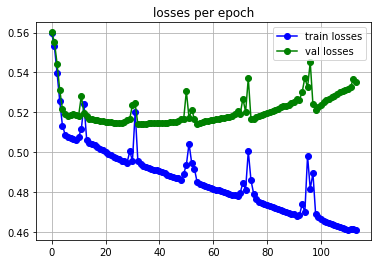

In [14]:
# running the model

try:
    sess
except NameError:
    pass
else:
    sess.close()

sess = tf.Session() # we don't want to close the session

learning_rate=.001
epochs=150
l2_loss_term = .001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
# ce_loss_term = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=l3))
loss = ce_loss_term
# + l2_loss_term
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

min_acc_auc = (math.inf, math.inf)

sess.run(init)

val_accs = []
val_aucs = []
train_losses = []
val_losses = []

# tensorboard doesn't work with tensorflow 1 anymore... 
# ill fucking switch to pytorch before touching tf2
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_file_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
# test_file_writer = tf.summary.FileWriter(test_log_dir, sess.graph)

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    _, prev_run_scores, _, prev_best_auc_run = pickle.load(prev_run_file)
    _, prev_best_aucs = prev_run_scores[prev_best_auc_run]

cur_best_auc = 0
cur_best_train_loss = math.inf

for epoch in tqdm(range(epochs), leave=False):
    print("epoch", epoch)
    print("training")
    for b_user_Xs, b_movie_Xs, b_genres, b_ys in batchify(user_Xs, movie_Xs, train_genres, ys, batch_size=746661, shuffle=False):
        feed_dict = {user_slice_idxs: b_user_Xs, 
                     movie_slice_idxs: b_movie_Xs, 
                     movie_genre_embeddings: b_genres,
#                      tags: b_tags,
                     y_true: b_ys}
        outs = (train_step, loss, l2_loss_term, ce_loss_term)
        _, lossval, l2_lossval, mse_lossval = sess.run(outs, feed_dict=feed_dict)
#         print("pred_ys", pred_y_val, "true_ys", b_ys[:5])
        print("train loss", lossval, "l2", l2_lossval, "mse", mse_lossval)

#         with train_file_writer as writer:
#             writer.add_summary(tf.summary.scalar("loss", loss))

    feed_dict = {user_slice_idxs: user_val_Xs,
                movie_slice_idxs: movie_val_Xs,
                movie_genre_embeddings: val_genres,
#                 tags: val_tags,
                y_true: val_ys}
    val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
    flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
    flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]

    print("val loss", val_loss_val)
    acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
    fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
    auc = metrics.auc(fpr, tpr)
    print("val acc", acc, "val auc", auc)
    min_acc_auc = min(min_acc_auc, (acc, auc))
    val_accs.append(acc)
    val_aucs.append(auc)
    val_losses.append(val_loss_val)
    
    plt.clf()
    plt.title("val aucs per epoch")
    plt.grid(b=True)
    plt.minorticks_on()
    plt.plot(prev_best_aucs, marker='o', color="grey")
    plt.plot(val_aucs, marker='o', color="black")
    plt.savefig("cur_val_aucs.png")
    
#     train_loss = sess.run((loss), feed_dict={user_slice_idxs: user_Xs, 
#                      movie_slice_idxs: movie_Xs, 
#                      movie_genre_embeddings: train_genres,
#                      y_true: ys})
    train_loss = lossval
    train_losses.append(train_loss)
    plt.clf()
    fig, ax = plt.subplots()
    plt.title("losses per epoch")
    ax.grid(b=True)
    ax.minorticks_on()
    train_losses_plot = ax.plot(train_losses, marker='o', color="blue", label="train losses")
    val_losses_plot = ax.plot(val_losses, marker='o', color="green", label="val losses")
    ax.legend()
    
    plt.savefig("cur_train_loss.png")

    if auc > cur_best_auc:
        print(f"NEW BEST AUC: {auc} @ epoch {epoch}")
    if train_loss < cur_best_train_loss:
        print(f"NEW BEST TRAIN LOSS: {train_loss} @ epoch {epoch}")
    
    cur_best_auc = max(cur_best_auc, auc)
    cur_best_train_loss = min(train_loss, cur_best_train_loss)
    if auc < cur_best_auc * .9 and epoch > 10:
        print("detecting large amounts of overfitting - stopping to avoid boiling oceans")
        break

#     with test_file_writer as writer:
#         writer.add_summary(value=[tf.summary.Value(tag="loss", simple_value=val_loss_val)])
#         writer.add_summary(tf.summary.scalar("loss", loss))
#         writer.add_summary(value=[tf.summary.Value(tag="acc", simple_value=acc)])
#         writer.add_summary(value=[tf.summary.Value(tag="auc", simple_value=auc)])


In [12]:
# save test prediction as file

test_y_preds = []

for b_user_Xs, b_movie_Xs, b_genres in batchify(user_test_Xs, movie_test_Xs, test_genres, batch_size=497774, shuffle=False):
    feed_dict = {user_slice_idxs: b_user_Xs,
                movie_slice_idxs: b_movie_Xs,
                movie_genre_embeddings: b_genres}
    test_y_preds.extend(sess.run(pred_y, feed_dict=feed_dict))
    
test_y_preds = [pred[0]/(pred[0]+pred[1]) for pred in test_y_preds]

df = pandas.DataFrame(test_y_preds, columns=['rating'])

with open("test_preds.csv", "w+") as test_file:
    test_file.write("Id"+df.to_csv())

KeyboardInterrupt: 

In [38]:
print(test_y_preds[:10])

[[ 1.          0.95304582]
 [ 2.          0.38410283]
 [ 3.          0.9537229 ]
 [ 4.          0.96523868]
 [ 5.          0.57257932]
 [ 6.          0.77299195]
 [ 7.          0.94740396]
 [ 8.          0.90670397]
 [ 9.          0.71593777]
 [10.          0.81709064]]


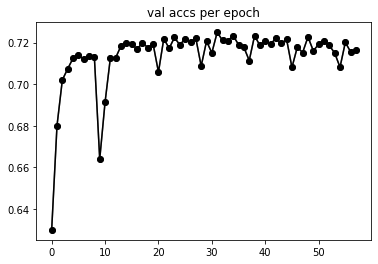

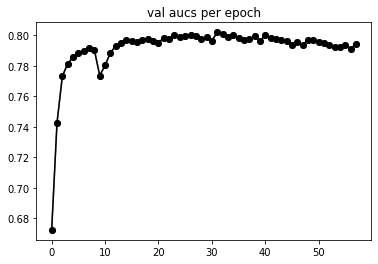

best run: 31


In [13]:
# im reduced to manually tensorboarding like a loser cause tf2 api is being a dick not my fault

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    cur_run, run_scores, best_auc, best_auc_run = pickle.load(prev_run_file)

run_scores[cur_run] = (val_accs, val_aucs)
if max(val_aucs) > best_auc:
    best_auc, best_auc_run = val_aucs[-1], cur_run

cur_run += 1
best_accs, best_aucs = run_scores[best_auc_run]

with open("prev_run_stats.pickle", "wb+") as prev_run_file:
    pickle.dump((cur_run, run_scores, best_auc, best_auc_run), prev_run_file)

plt.title("val accs per epoch")
plt.plot(best_accs, marker='o', color="grey")
plt.plot(val_accs, marker='o', color="black")
plt.show()

plt.title("val aucs per epoch")
plt.plot(best_aucs, marker='o', color="grey")
plt.plot(val_aucs, marker='o', color="black")
plt.show()

print(f"best run: {best_auc_run}")

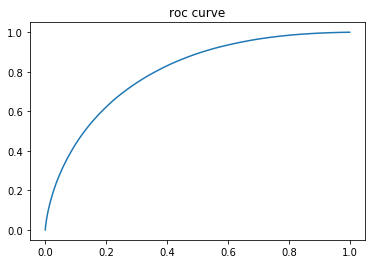

In [17]:
fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)

plt.title("roc curve")
plt.plot(fpr, tpr)
plt.show()


In [ ]:
# prediction acc by user and by movie
plt.rcParams['figure.dpi'] = 300

user_correct_ct = defaultdict(lambda: 0)
user_total_ct = defaultdict(lambda: 0)
movie_correct_ct = defaultdict(lambda: 0)
movie_total_ct = defaultdict(lambda: 0)
for uid, mid, y_true, pred_y in tqdm(zip(user_val_Xs, movie_val_Xs, val_ys, val_y_pred)):
    uid = uid[0]
    mid = mid[0]
    if (y_true[0] > y_true[1]) == (pred_y[0] > pred_y[1]):
        user_correct_ct[uid] += 1
        movie_correct_ct[mid] += 1
    user_total_ct[uid] += 1
    movie_total_ct[mid] += 1

user_accs = defaultdict(lambda: -1)
movie_accs = defaultdict(lambda: -1)
for uid, total in tqdm(user_total_ct.items()):
    if total > 100:
        correct_ct = user_correct_ct[uid]
        user_accs[uid] = correct_ct/total

for mid, total in tqdm(movie_total_ct.items()):
    if total > 100:
        correct_ct = movie_correct_ct[mid]
        movie_accs[mid] = correct_ct/total

plt.title("prediction acc histogram by user when number of train examples > 100")
plt.hist(user_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of users w that acc")
plt.show()
plt.title("prediction acc histogram by movie when number of train examples > 100")
plt.hist(movie_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of movies w that acc")
plt.show()

user_accs = defaultdict(lambda: -1)
movie_accs = defaultdict(lambda: -1)
for uid, total in tqdm(user_total_ct.items()):
    correct_ct = user_correct_ct[uid]
    user_accs[uid] = correct_ct/total

for mid, total in tqdm(movie_total_ct.items()):
    correct_ct = movie_correct_ct[mid]
    movie_accs[mid] = correct_ct/total

plt.title("prediction acc histogram by user")
plt.hist(user_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of users w that acc")
plt.show()
plt.title("prediction acc histogram by movie")
plt.hist(movie_accs.values(), bins=100)
plt.xlabel("acc")
plt.ylabel("# of movies w that acc")
plt.show()

user_train_examples_ct = defaultdict(lambda: 0)
movie_train_examples_ct = defaultdict(lambda: 0)

for uid, mid in zip(user_Xs, movie_Xs):
    user_train_examples_ct[uid[0]] += 1
    movie_train_examples_ct[mid[0]] += 1

user_acc_examples = np.array([(user_accs[uid], ct) for uid, ct in user_train_examples_ct.items()])
movie_acc_examples = np.array([(acc, movie_train_examples_ct[mid]) for mid, acc in movie_accs.items()])
plt.title("user acc against number of examples")
plt.scatter(user_acc_examples[:, 0], user_acc_examples[:, 1], c=[[0, 0, 1, .05]], s=1)
plt.xlabel("acc")
plt.ylabel("number of train examples seen for that user")
plt.show()
plt.title("movie acc against number of examples")
plt.scatter(movie_acc_examples[:, 0], movie_acc_examples[:, 1], c=[[0, 0, 1, .05]], s=1)
plt.xlabel("acc")
plt.ylabel("number of train examples seen for that movie")
plt.show()

# conclusion: highest acc gains can be made by tailoring movie suggestions to specific users with low information

In [15]:
# prediction acc by genre

genre_correct_ct = defaultdict(lambda: 0)
genre_total_ct = defaultdict(lambda: 0)

movie_genres_one_hot = get_movie_genres_one_hot()
for uid, mid, y_true, pred_y in tqdm(zip(user_val_Xs, movie_val_Xs, val_ys, val_y_pred)):
    genres = movie_genres_one_hot[mid[0]]
    correct = (y_true[0] > y_true[1]) == (pred_y[0] > pred_y[1])
    for i, genre in enumerate(genres):
        if genre == 1:
            genre_correct_ct[i] += correct
            genre_total_ct[i] += 1

print("prediction acc by genre")
for genre_id, total in genre_total_ct.items():
    correct_ct = genre_correct_ct[genre_id]
    print(genre_id, correct_ct/total)
    
# conclusion: genre can't really be mined for more information i think


prediction acc by genre
0 0.702662007725544
2 0.7169578622816033
9 0.7200113433857658
1 0.717148152534723
8 0.7134642711963338
11 0.7094245842095201
13 0.7104643921159381
3 0.7040078741330127
4 0.7261100807331442
5 0.7160645674624975
10 0.7009188973232121
17 0.7186280374896733
6 0.7302657182568882
14 0.6779070352300407
15 0.6906036718316583
12 0.7149278551944809
16 0.7106273123861063
19 0.7158106637649619
7 0.6750991127053049


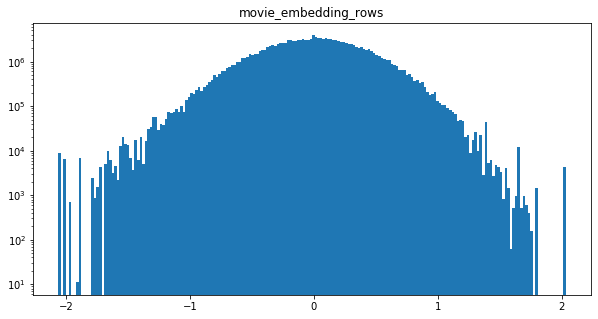

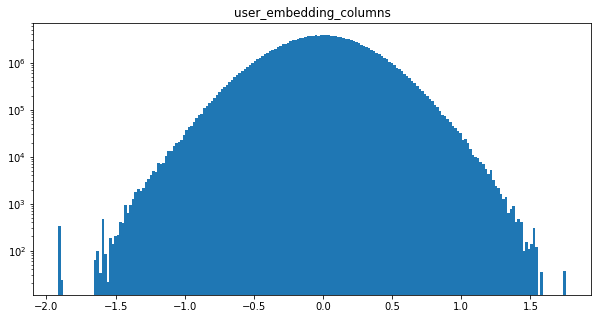

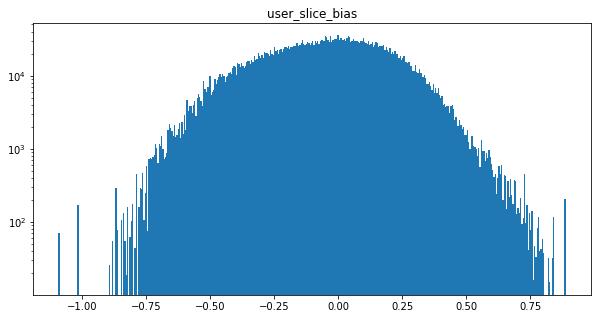

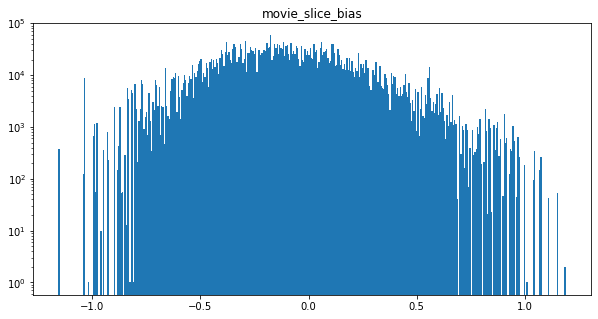

In [19]:
plt.rc('figure', figsize=(10, 5))
plt.title("movie_embedding_rows")
plt.hist(sess.run(movie_embedding_rows, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_embedding_columns")
plt.hist(sess.run(user_embedding_columns, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_slice_bias")
plt.hist(sess.run(user_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()
plt.title("movie_slice_bias")
plt.hist(sess.run(movie_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()

In [ ]:
mode1 = np.random.normal(0, 1, 5000000)
mode2 = np.random.normal(-2, 1, 1000000)

plt.hist(np.concatenate((mode1, mode2)), bins=100, log=True)
plt.show()
plt.hist(mode1, bins=100, log=True, color="blue")
plt.hist(mode2, bins=100, log=True, color="blue")
plt.show()


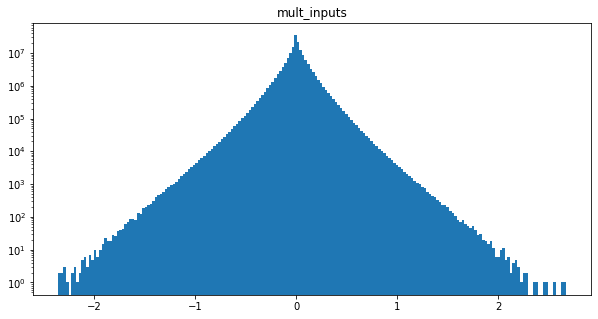

avg pos -0.00021177795315711342 pos ct 76948440
avg neg -4.119220633618965e-05 neg ct 83021000


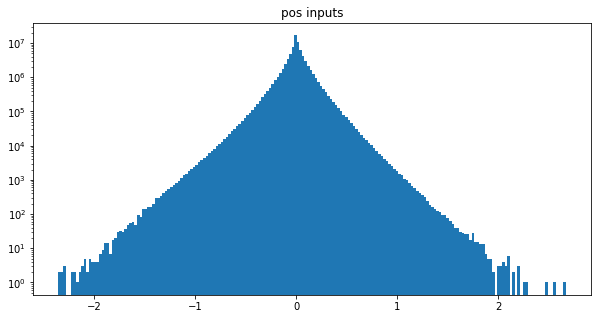

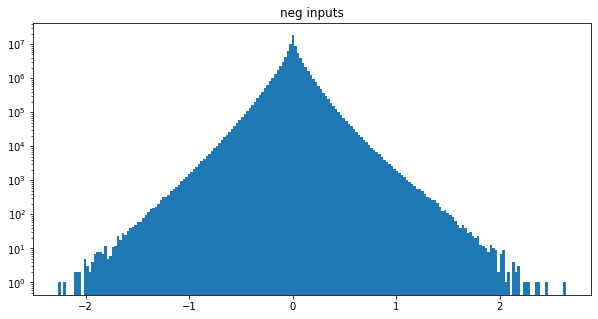

In [20]:
mult_inputs = sess.run(mult_input, feed_dict)
plt.cla()
plt.title("mult_inputs")
plt.hist(mult_inputs.flatten(), log=True, bins=200)
plt.show()

pred_ys = sess.run(pred_y, feed_dict)

mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
if len(mult_input_pos) > 0:
    print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
else:
    print("mult_input_pos", mult_input_pos)

mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
if len(mult_input_neg) > 0:
    print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
else:
    print("mult_input_neg", mult_input_neg)

plt.title("pos inputs")
plt.hist(mult_input_pos, bins=200, log=True)
plt.show()
plt.title("neg inputs")
plt.hist(mult_input_neg, bins=200, log=True)
plt.show()

# makes sense why these are basically chi square - composed of normal distributions multiplied together which is fundamentally what we're predicting

In [ ]:
# script to run the model on training and validation data to submit
# running the model
import string

try:
    sess
except NameError:
    pass
else:
    sess.close()

sess = tf.Session() # we don't want to close the session

expr_num = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))

print(f"starting experiment {expr_num}")
expr_path = Path("models")/expr_num
os.makedirs(expr_path, exist_ok=False)

learning_rate=.001
epochs=50
# save_epochs = {70, 72, 74, 76, 78, 90, 100, 110}

l2_loss_term = .001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
# ce_loss_term = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=l3))
loss = ce_loss_term
# + l2_loss_term
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

sess.run(init)

cur_best_auc = 0

min_loss = math.inf
train_losses = []
for epoch in tqdm(range(epochs), leave=False):
    print("epoch", epoch)
    print("training")
    arg_len = len(user_val_Xs), len(user_Xs)
    
    
    train_val_user_Xs = np.concatenate([user_val_Xs, user_Xs], axis=0)
    train_val_movie_Xs = np.concatenate([movie_val_Xs, movie_Xs], axis=0)
    train_val_genres = np.concatenate([val_genres, train_genres], axis=0)
    train_val_ys = np.concatenate([val_ys, ys], axis=0)
    for b_user_Xs, b_movie_Xs, b_genres, b_ys in batchify(train_val_user_Xs, train_val_movie_Xs, train_val_genres, train_val_ys, batch_size=746661, shuffle=True):
        feed_dict = {user_slice_idxs: b_user_Xs, 
                     movie_slice_idxs: b_movie_Xs, 
                     movie_genre_embeddings: b_genres,
                     y_true: b_ys}
        outs = (train_step, loss)
        _, lossval = sess.run(outs, feed_dict=feed_dict)
        print("train loss", lossval, "l2", l2_lossval, "mse", mse_lossval)

    train_loss = sess.run(loss, feed_dict={user_slice_idxs: train_val_user_Xs, 
                     movie_slice_idxs: train_val_movie_Xs, 
                     movie_genre_embeddings: train_val_genres,
                     y_true: train_val_ys})
    
    train_losses.append(train_loss)
    plt.clf()
    fig, ax = plt.subplots()
    plt.title("losses per epoch")
    ax.grid(b=True)
    ax.minorticks_on()
    train_losses_plot = ax.plot(train_losses, marker='o', color="blue", label="train losses")
    ax.legend()
    
    plt.savefig("cur_train_loss.png")

    
    if epoch > 5 and epoch % 2 == 0:
        cur_submission_num += 1
        save_path = expr_path/f"expr_{expr_num}_epoch_{epoch}_loss_{train_loss}"
        print(f"saving candidate submission {save_path}")

        os.makedirs(save_path/"model", exist_ok=True)
        saver = tf.train.Saver()
        saver.save(sess, str(save_path/"model"/"model.ckpt"))

        test_y_preds = []

        for b_user_Xs, b_movie_Xs, b_genres in batchify(user_test_Xs, movie_test_Xs, test_genres, batch_size=497774, shuffle=False):
            feed_dict = {user_slice_idxs: b_user_Xs,
                        movie_slice_idxs: b_movie_Xs,
                        movie_genre_embeddings: b_genres}
            test_y_preds.extend(sess.run(pred_y, feed_dict=feed_dict))

        test_y_preds = [pred[0]/(pred[0]+pred[1]) for pred in test_y_preds]

        df = pandas.DataFrame(test_y_preds, columns=['rating'])

        with open(save_path/"test_preds.csv", "w+") as test_file:
            test_file.write("Id"+df.to_csv())

        os.system(f"cp basic_nn.ipynb {str(save_path)}")

#         with open("submission_info.pickle", "wb") as submission_info_file:
#             pickle.dump(cur_submission_num, submission_info_file)

starting experiment G94UT6SBAV


epoch 0
training
train loss 0.5652496744476239 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5645683836622711 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5639976734065467 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5634156152095556 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.562884268153996 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5624629478989001 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5620419854397721 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5616974455530761 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5613117671757857 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5610029462080675 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5606925246301309 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5603665157392352 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5600916734623116 l2 0.6873014138764203 mse 0.46973829433580

train loss 0.5099733154557734 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5102761891195206 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5099971154841529 l2 0.6873014138764203 mse 0.46973829433580344
epoch 5
training
train loss 0.5088965219744471 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5091012060522337 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5089128955257888 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5088783253670154 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.509119952127764 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5092507865657447 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5091232345399823 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5091184741168282 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.508666103407496 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5087633432025266 l2 0.6873014138764203 mse 0.469738294335803

train loss 0.5061988019417627 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5061104061981568 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5065108602642528 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5062505857842489 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5060461886961702 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5060452392094505 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5062024261540282 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5062484283234155 l2 0.6873014138764203 mse 0.46973829433580344
epoch 10
training
train loss 0.5048287423775631 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5045904797438518 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5048276509886602 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5046158987921545 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5048921774791585 l2 0.6873014138764203 mse 0.469738294335

train loss 0.5002768072320964 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5004758000716356 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5001123461581831 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5004395769561903 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5005620860594073 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5001717322483924 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5002633128266549 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5004821438981447 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5006914569459706 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5005743904244184 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5009638752093297 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5007665468851618 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.5003548384201457 l2 0.6873014138764203 mse 0.46973829433580344
saving candi

train loss 0.4923863834665383 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49266329680010673 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4924967684503267 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49261928604561045 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49289384685744686 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4925060158135342 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49277731387709917 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49274431840934824 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4931087834035087 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4932377708959901 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49318215358081213 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4932751312357793 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4933480159076786 l2 0.6873014138764203 mse 0.46973829433580344
train 

/home/lucastong/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch 20
training
train loss 0.4909236478615265 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49100017374321353 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4909031857889557 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4910086307999917 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4912545516413849 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4909897844055323 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49103928189992135 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.491049829748903 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.491528153467418 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49143725000298993 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4916967065683325 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.49157199674892227 l2 0.6873014138764203 mse 0.46973829433580344
train loss 0.4914173848336199 l2 0.6873014138764203 mse 0.4697382943